In [1]:
from __future__ import annotations

from collections import defaultdict
from dataclasses import dataclass

from sklearn.linear_model import LogisticRegression
import networkx as nx
import igraph as ig
import numpy as np
import pandas as pd
import bcubed

from epilink import (
    TOIT,
    InfectiousnessParams,
    populate_epidemic_data,
    simulate_genomic_data,
    generate_pairwise_data,
    estimate_linkage_probabilities,
)

from utils import *

set_seaborn_paper_context()

In [2]:

@dataclass(frozen=True)
class Config:
    # Time binning for 'available' snapshots
    step_days: int = 7

    # Early window used for tuning (in available_time *indices*)
    train_max_time_index: int = 2

    # Leiden settings
    n_restarts: int = 10
    min_prob_weight: float = 1e-4
    gammas: tuple[float, ...] = tuple(np.round(np.arange(0, 1 + 1e-9, 0.05), 10))

    # SNP thresholds for score graphs
    snp_thresholds: tuple[int, ...] = (0, 1, 2, 3, 4, 5)

CFG = Config()

In [3]:
# ----------------------------
# Data: load transmission tree + simulate pairwise data
# ----------------------------

figs_dir = Path("../figures/main")
sup_figs_dir = Path("../figures/supplementary")
sup_tabs_dir = Path("../tables/supplementary")
tabs_dir = Path("../tables/main")
sup_figs_dir = sup_figs_dir / "stability"

ensure_dirs(figs_dir, sup_figs_dir, tabs_dir, sup_tabs_dir)

trans_tree_path = Path("../data/processed/synthetic/scovmod_tree.gml")
trans_tree = nx.read_gml(trans_tree_path)

In [4]:
def hart_default_params() -> InfectiousnessParams:
    return InfectiousnessParams(
        k_inc=5.807,
        scale_inc=0.948,
        k_E=3.38,
        mu=0.37,
        k_I=1,
        alpha=2.29,
    )

params = hart_default_params()
toit = TOIT()

populated_tree = populate_epidemic_data(toit=toit, tree=trans_tree)

gen_results = simulate_genomic_data(toit=toit, tree=populated_tree)

pairwise = generate_pairwise_data(
    packed_genomic_data=gen_results["packed"],
    tree=populated_tree,
)


Simulating mutations along transmission tree...
Packing data into 2-bit format...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Computing genetic distances...
Computing 64-bit Hamming distances for 4990 sequences...
Computing 64-bit Hamming distances for 4990 sequences...
Computing temporal distances...
Mapping topological relationships...
Constructing DataFrame...


In [5]:
# ----------------------------
# Metadata: when does each case become available?
# ----------------------------

def sampling_times(tree: nx.Graph, step: int = 7) -> pd.DataFrame:
    """Create per-case availability bins.

    Returns:
      case_meta with columns:
        - node (original node label)
        - sampling_time (rounded day)
        - available_bin_start (day for bin start)
        - available_time (0..K-1 index of availability time)

    Notes:
      We keep both the *bin start day* and a compact integer index.
    """
    sampling = {n: int(round(d)) for n, d in tree.nodes(data="sample_date")}
    case_meta = pd.DataFrame({
        "node": list(sampling.keys()),
        "sampling_time": list(sampling.values()),
    })

    tmin = case_meta["sampling_time"].min()
    tmax = case_meta["sampling_time"].max()

    cuts = np.arange(tmin, tmax + step, step)
    idx = cuts.searchsorted(case_meta["sampling_time"].values, side="right") - 1
    idx = idx.clip(0, len(cuts) - 1)

    case_meta["available_bin_start"] = cuts[idx]

    # Convert to 0..K-1 indices but keep available_bin_start for plotting/interpretation
    case_meta = case_meta.sort_values(["available_bin_start", "sampling_time"]).reset_index(drop=True)
    codes, _ = pd.factorize(case_meta["available_bin_start"], sort=True)
    case_meta["available_time"] = codes

    # Keep a stable order
    case_meta = case_meta.sort_values("sampling_time").reset_index(drop=True)

    return case_meta

sample_dates = sampling_times(populated_tree, step=CFG.step_days)


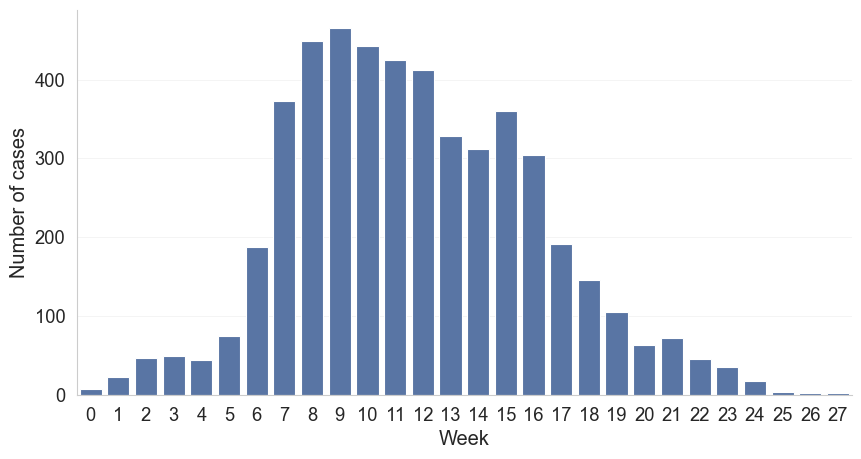

In [6]:
fig = plt.figure(figsize=(10, 5))
sns.countplot(sample_dates, x="available_time")
plt.xlabel("Week")
plt.ylabel("Number of cases")
save_figure(fig, sup_figs_dir / "case_counts_over_time", ["png", "pdf"])
plt.show()

In [7]:
# ----------------------------
# Build edge weights
# ----------------------------

# Mechanistic probabilities
pairwise["MechProbLinearDist"] = estimate_linkage_probabilities(
    toit=toit,
    genetic_distance=pairwise["LinearDist"].values,
    temporal_distance=pairwise["TemporalDist"].values,
)

pairwise["MechProbPoissonDist"] = estimate_linkage_probabilities(
    toit=toit,
    genetic_distance=pairwise["PoissonDist"].values,
    temporal_distance=pairwise["TemporalDist"].values,
)

# Logistic regression baseline (trained on an early window)
initial_nodes = set(sample_dates.loc[sample_dates["available_time"] <= CFG.train_max_time_index, "node"])
initial_data = pairwise[
    pairwise["NodeA"].isin(initial_nodes) &
    pairwise["NodeB"].isin(initial_nodes)
]

y = initial_data["Related"].astype(int).values
for dist_col in ("LinearDist", "PoissonDist"):
    X = initial_data[["TemporalDist", dist_col]].values
    col = f"LogitProb{dist_col}"
    clf = LogisticRegression(solver="lbfgs", max_iter=200)
    clf.fit(X, y)
    pairwise[col] = clf.predict_proba(pairwise[["TemporalDist", dist_col]].values)[:, 1]

# Simple inverse distance scores (bigger score = closer)
pairwise["LinearDistScore"] = 1.0 / (pairwise["LinearDist"] + 1.0)
pairwise["PoissonDistScore"] = 1.0 / (pairwise["PoissonDist"] + 1.0)

In [8]:
# ----------------------------
# Helpers: graph building, truth memberships, and BCubed
# ----------------------------

def build_igraph(
    df: pd.DataFrame,
    weight_col: str,
    minimum_weight: float = None,
    probability: bool = True,
    all_nodes: list = None,
) -> ig.Graph:
    """Build an undirected igraph graph from an edge list.

    Important: if `all_nodes` is provided, we explicitly add isolated vertices so
    nodes don't disappear under thresholding (this matters for stability over time).
    """
    work = df[["NodeA", "NodeB", weight_col]].copy()

    if minimum_weight is not None:
        if probability:
            work = work[work[weight_col] >= float(minimum_weight)]
        else:
            # If user passes SNP threshold k, scores are 1/(k+1)
            thr = 1.0 / (float(minimum_weight) + 1.0)
            work = work[work[weight_col] >= thr]

    edges = work[["NodeA", "NodeB", weight_col]].to_records(index=False).tolist()

    g = ig.Graph.TupleList(
        edges=edges,
        directed=False,
        vertex_name_attr="case_id",
        edge_attrs=weight_col,
    )

    if all_nodes is not None:
        present = set(g.vs["case_id"]) if g.vcount() else set()
        missing = [n for n in all_nodes if n not in present]
        if missing:
            g.add_vertices(missing, attributes={"case_id": missing})
    return g

def build_ground_truth_memberships(tree_path: Path) -> dict[int, set[int]]:
    g = ig.Graph.Read_GML(str(tree_path))

    clusters = []
    for node_id in range(g.vcount()):
        neighbours = set(g.successors(node_id))
        c = {node_id} | neighbours
        c = [g.vs[i]["label"] for i in c]
        clusters.append(c)

    membership = defaultdict(set)
    for clus_id, clus in enumerate(clusters):
        for node in clus:
            membership[int(node)].add(int(clus_id))
    return membership

def bcubed_scores(
        pred: dict[int, set[int]],
        truth: dict[int, set[int]]
) -> tuple[float, float, float]:
    cases = sorted(set(pred) & set(truth))

    pred = {c: pred[c] for c in cases if pred[c]}
    truth = {c: truth[c] for c in cases if truth[c]}

    if not pred or not truth:
        raise ValueError("No valid cases with non-empty memberships")

    precision = bcubed.precision(pred, truth)
    recall = bcubed.recall(pred, truth)
    f_score = bcubed.fscore(precision, recall)
    return precision, recall, f_score

## Tune hyperparameters on an early window

In [9]:
# Early window subset used for tuning
initial_nodes = set(sample_dates.loc[sample_dates["available_time"] <= CFG.train_max_time_index, "node"])
initial_data = pairwise[
    pairwise["NodeA"].isin(initial_nodes) &
    pairwise["NodeB"].isin(initial_nodes)
]

truth = build_ground_truth_memberships(trans_tree_path)

In [10]:
# ---- 1) Tune Leiden resolution for probability weights

prob_weight_columns = [
    "MechProbLinearDist",
    "MechProbPoissonDist",
    "LogitProbLinearDist",
    "LogitProbPoissonDist",
]

metrics_rows = []

rows = []
for weight in prob_weight_columns:
    graph = build_igraph(
        initial_data[["NodeA", "NodeB", weight]],
        weight,
        minimum_weight=CFG.min_prob_weight,
        probability=True,
        all_nodes=sorted(initial_nodes),
    )

    for gamma in CFG.gammas:
        best = None
        best_q = -np.inf

        # Restarts help avoid local optima
        for _ in range(CFG.n_restarts):
            part = graph.community_leiden(
                weights=weight,
                resolution=float(gamma),
                n_iterations=-1,
            )

            q = graph.modularity(
                        membership=part,
                        weights=weight,
                        resolution=gamma,
                        directed=False)

            if q > best_q:
                best_q = q
                best = part

        memb = best.membership if best is not None else None

        if memb is None:
            memb = list(range(graph.vcount()))
        rows.append(pd.DataFrame({
            "case_id": graph.vs["case_id"],
            "gamma": gamma,
            "cluster_id": np.array(memb, dtype=int),
            "weight": weight,
        }))

partitions = pd.concat(rows, ignore_index=True)

# --- Clustering evaluation against ground truth
for (weight, gamma), sub in partitions.groupby(["weight", "gamma"], observed=True):
    pred = dict(zip(sub["case_id"].tolist(), sub["cluster_id"].tolist()))
    pred = {int(k): {int(v)} for k, v in pred.items()}  # make non-overlapping into overlapping
    prec, rec, f1 = bcubed_scores(pred=pred, truth=truth)
    metrics_rows.append({
        "gamma": float(gamma),
        "Weight": weight,
        "BCubed_Precision": prec,
        "BCubed_Recall": rec,
        "BCubed_F1_Score": f1,
        "N_cases": len(pred),
    })

eval_metrics = pd.DataFrame(metrics_rows)

idx = eval_metrics.groupby("Weight")["BCubed_F1_Score"].idxmax()
best_f1 = eval_metrics.loc[idx, ["Weight", "BCubed_F1_Score", "gamma"]]
model_res = best_f1.set_index("Weight")["gamma"].to_dict()

### Tune SNP thresholds for score graphs (connected components)

In [11]:
score_weight_columns = [
    "LinearDistScore",
    "PoissonDistScore",
]

metrics_rows = []
rows = []

for weight in score_weight_columns:
    for snp in CFG.snp_thresholds:
        graph = build_igraph(
            initial_data[["NodeA", "NodeB", weight]],
            weight,
            minimum_weight=snp,
            probability=False,
            all_nodes=sorted(initial_nodes),
        )

        cluster = graph.connected_components(mode="weak")

        memb = cluster.membership if cluster is not None else None

        if memb is None:
            memb = list(range(graph.vcount()))
        rows.append(pd.DataFrame({
            "case_id": graph.vs["case_id"],
            "snp": snp,
            "cluster_id": np.array(memb, dtype=int),
            "weight": weight,
        }))

partitions = pd.concat(rows, ignore_index=True)

# --- Clustering evaluation against ground truth
for (weight, snp), sub in partitions.groupby(["weight", "snp"], observed=True):
    pred = dict(zip(sub["case_id"].tolist(), sub["cluster_id"].tolist()))
    pred = {int(k): {int(v)} for k, v in pred.items()}  # make non-overlapping into overlapping
    prec, rec, f1 = bcubed_scores(pred=pred, truth=truth)
    metrics_rows.append({
        "snp": snp,
        "Weight": weight,
        "BCubed_Precision": prec,
        "BCubed_Recall": rec,
        "BCubed_F1_Score": f1,
        "N_cases": len(pred),
    })

eval_metrics = pd.DataFrame(metrics_rows)

idx = eval_metrics.groupby("Weight")["BCubed_F1_Score"].idxmax()
best_f1 = eval_metrics.loc[idx, ["Weight", "BCubed_F1_Score", "snp"]]
model_snp = best_f1.set_index("Weight")["snp"].to_dict()


In [12]:
model_res, model_snp

({'LogitProbLinearDist': 0.4,
  'LogitProbPoissonDist': 0.15,
  'MechProbLinearDist': 0.15,
  'MechProbPoissonDist': 0.1},
 {'LinearDistScore': 0, 'PoissonDistScore': 1})

## Stability definitions

For case $i$:

Let $C_t(i)$ be the set of nodes in $i$’s cluster at time $t$, and $C_{t+1}(i)$ similarly.

- Forward: $\frac{|C_t \cap C_{t+1}|}{|C_{t+1}|}$  → “how much of my current cluster was already together”
- Backward: $\frac{|C_t \cap C_{t+1}|}{|C_t|}$  → “how much of my previous cluster stayed together”
- Jaccard: $\frac{|C_t \cap C_{t+1}|}{|C_t \cup C_{t+1}|}$  → symmetric stability


In [13]:
# ----------------------------
# Cumulative clustering + stability
# ----------------------------

def run_clustering(
    df: pd.DataFrame,
    nodes_present: set,
    weight_col: str,
    resolution: float | None = None,
    minimum_weight: float | None = None,
    probability: bool = True,
) -> dict:
    g = build_igraph(
        df[["NodeA", "NodeB", weight_col]],
        weight_col,
        minimum_weight=minimum_weight,
        probability=probability,
        all_nodes=sorted(nodes_present),
    )

    if probability:
        best = None
        best_q = -np.inf

        for _ in range(CFG.n_restarts):
            part = g.community_leiden(
                weights=weight_col,
                resolution=resolution,
                n_iterations=-1,
            )

            # Tie-breaker: modularity (don’t pass restart index)
            q = g.modularity(membership=part, weights=weight_col)

            if q > best_q:
                best_q = q
                best = part

        memb = best.membership if best is not None else None
    else:
        part = g.connected_components(mode="weak")
        memb = part.membership if part is not None else None

    if memb is None:
        memb = list(range(g.vcount()))

    return dict(zip(g.vs["case_id"], memb))


def subset_pairs(df: pd.DataFrame, nodes_present: set) -> pd.DataFrame:
    m = df["NodeA"].isin(nodes_present) & df["NodeB"].isin(nodes_present)
    return df.loc[m].copy()


def make_cluster_sets(labels: dict) -> dict:
    clusters = defaultdict(set)
    for n, c in labels.items():
        clusters[c].add(n)
    return clusters


def overlap_metrics_between(labels_t: dict, labels_t1: dict) -> pd.DataFrame:
    """Per-node overlap between two consecutive snapshots.

    We compute overlap only for nodes present at both times (nodes newly arriving at t+1
    are excluded).
    """
    clusters_t = make_cluster_sets(labels_t)
    clusters_t1 = make_cluster_sets(labels_t1)

    common_nodes = sorted(set(labels_t).intersection(labels_t1))

    rows = []
    for n in common_nodes:
        Ct = clusters_t[labels_t[n]]
        Ct1 = clusters_t1[labels_t1[n]]

        inter = Ct & Ct1
        union = Ct | Ct1

        O = len(inter)
        rows.append({
            "node": n,
            "forward": O / len(Ct1) if len(Ct1) else float("nan"),
            "backward": O / len(Ct) if len(Ct) else float("nan"),
            "jaccard": O / len(union) if len(union) else float("nan"),
            "Ct_size": len(Ct),
            "Ct1_size": len(Ct1),
            "overlap_size": O,
        })

    return pd.DataFrame(rows)


def cumulative_stability(
    pairwise_df: pd.DataFrame,
    case_meta: pd.DataFrame,
    weight_col: str,
    resolution: float | None = None,
    minimum_weight: float | None = None,
    probability: bool = True,
) -> pd.DataFrame:
    """Run cumulative clustering and compute overlap metrics for each transition."""

    times = sorted(case_meta["available_time"].unique())

    transitions = []
    prev_t = None
    prev_labels = None

    for t in times:
        nodes_present = set(case_meta.loc[case_meta["available_time"] <= t, "node"])
        sub_df = subset_pairs(pairwise_df, nodes_present)

        labels = run_clustering(
            sub_df,
            nodes_present=nodes_present,
            weight_col=weight_col,
            resolution=resolution,
            minimum_weight=minimum_weight,
            probability=probability,
        )

        if prev_labels is not None:
            df = overlap_metrics_between(prev_labels, labels)
            df.insert(0, "t", prev_t)
            df.insert(1, "t1", t)
            transitions.append(df)

        prev_t = t
        prev_labels = labels

    return pd.concat(transitions, ignore_index=True) if transitions else pd.DataFrame()


In [20]:
from matplotlib.axes import Axes

METHODS = {
    "mech_linear": {
        "weight_col": "MechProbLinearDist",
        "probability": True,
        "minimum_weight": CFG.min_prob_weight,
        "resolution": model_res["MechProbLinearDist"]
    },

     "mech_poisson": {
        "weight_col": "MechProbPoissonDist",
        "probability": True,
        "minimum_weight": CFG.min_prob_weight,
        "resolution": model_res["MechProbPoissonDist"]
    },

    "logit_linear": {
        "weight_col": "LogitProbLinearDist",
        "probability": True,
        "minimum_weight": CFG.min_prob_weight,
        "resolution": model_res["LogitProbLinearDist"]
    },

     "logit_poisson": {
        "weight_col": "LogitProbPoissonDist",
        "probability": True,
        "minimum_weight": CFG.min_prob_weight,
        "resolution": model_res["LogitProbPoissonDist"]
    },
    #
    # "snp_linear": {
    #     "weight_col": "LinearDistScore",
    #     "probability": False,
    #     "minimum_weight": model_snp["LinearDistScore"]
    # },
    #
    # "snp_poisson": {
    #     "weight_col": "PoissonDistScore",
    #     "probability": False,
    #     "minimum_weight": model_snp["PoissonDistScore"]
    # }
}

TITLE = {
    "mech_linear": "(a) Mechanistic (Deterministic)",
    "mech_poisson": "(b) Mechanistic (Stochastic)",
    "logit_linear": "(c) Logistic (Deterministic)",
    "logit_poisson": "(d) Logistic (Stochastic)",
    # "snp_linear": "(e) SNP (Deterministic)",
    # "snp_poisson": "(f) SNP (Stochastic)",
}

def plot_stability_over_time(summary: pd.DataFrame, method: str, ax: Axes) -> None:
    cols = ["forward", "backward", "jaccard"]
    missing = [c for c in cols if c not in summary.columns]
    if missing:
        raise ValueError(f"summary is missing columns: {missing}")

    for c, style in zip(cols, ["--", "-.", "-"]):
        ax.plot(summary.index, summary[c], linestyle=style, linewidth=2, label=c.capitalize())

    ax.set_xlabel("Week")
    ax.set_ylabel("Mean stability")
    ax.set_ylim(0, 1)
    ax.set_title(TITLE[method], loc='left', pad=20)

Analysing: mech_linear
Analysing: mech_poisson
Analysing: logit_linear
Analysing: logit_poisson


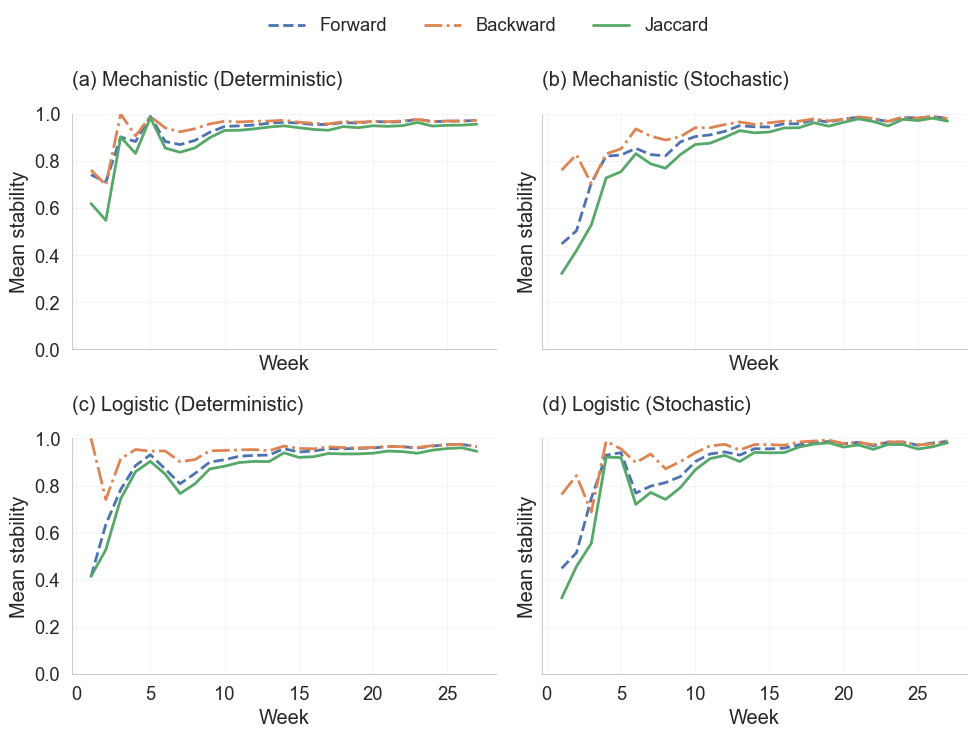

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 7), sharex=True, sharey=True)
axes = axes.flatten()


for i, (name, cfg) in enumerate(METHODS.items()):
    print(f"Analysing: {name}")
    stability_df = cumulative_stability(pairwise, sample_dates, **cfg)  # make sure this returns stability_df
    summary = stability_df.groupby("t1")[["forward", "backward", "jaccard"]].mean()
    summary.to_csv(tabs_dir / f"stability_summary_{name}.csv", index=False)
    plot_stability_over_time(summary, method=name, ax=axes[i])


handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,
           frameon=False, loc="upper center",
           ncol=3, bbox_to_anchor=(0.5, 1.07))

fig.tight_layout()
save_figure(fig, figs_dir / "cluster_stability", ["png", "pdf"])
plt.show()